##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">DO LABORATORIUM 3</style></h1>
    <h1 style = "font-size:24px">z Przetwarzania multimediów w systemach decyzyjnych</style></h1>
    <h1 style = "font-size:24px">Przegląd algorytmów uczących się metryk dystansu dla
danych wizyjnych</style></h1>
    <h1 style = "font-size:24px">Przemysław Rośleń</style></h1>
    <h3 style = "font-size:21px">algorytm straty trójkowej (triplet loss)</h3>
    <h3 style =
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

![stopka.svg](stopka.svg)

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# Trening sieci algorytmem straty trójkowej


Algorytm straty trójkowej jest mniej "zachłanny" jeśli chodzi o szybkie umieszczanie punktów w przestrzeni decyzyjnej. Zmniejsza to ryzyko słabej generalizacji modelu, jednak okupione jest wolniejszym treningiem.

In [ ]:
# Import bibliotek
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers     import Input, Dense, Conv2D, Flatten, PReLU, MaxPooling2D, Lambda
from tensorflow.keras.models     import Model
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras            import backend as K
from numpy.linalg                import norm
from sklearn.decomposition       import PCA
from tqdm                        import tqdm

# Nastawy pracy algorytmu:

In [ ]:
# Nastawy algorytmu treningu
learning_rate       = 0.001
batches_per_epoch   = 10
batch_size          = 16
num_training_epochs = 3

# Nastawy algorytmu uczącego się metryk odległości
embedding_length  = 20 # długość wektora reprezentacji
margin            = 1  # ograniczenie na docelową odległość między klastrami punktów
distance_norm     = 'euclidean' # metryka odległości Ln, może być też 1,2, czy np.inf

# Nazwy folderów na dane:
folder_model_weights    = "_weights"
folder_repspace_preview = "_previews"

Odczyt danych z reporytorium TensorFlow Datasets

In [ ]:
# Wykorzystamy zbiór MNIST.
trn_dst, test_dst = tfds.load('mnist', split=['train','test'], shuffle_files=True, as_supervised = True, batch_size=-1)

# Skrypt napisany jest z myślą, że zbiór danych podzielony jest
# na standardowe cztery tablice (X - wzorce wejściowe, Y - etykiety).
trn_X,   trn_Y  = tfds.as_numpy(trn_dst)
test_X,  test_Y = tfds.as_numpy(test_dst)

# Konwertujemy dane wejściowe na format zmiennoprzecinkowy:
trn_X  = trn_X.astype(np.float16)
test_X = test_X.astype(np.float16)

# Pobieramy informację o rozmiarze wejścia.
# (dla MNIST jest to (28, 28, 1))
input_dims = trn_X[0].shape

# Normalizacja danych:

def normalize_dataset(dataset):
    for i in range(len(dataset)):
        dataset[i] = dataset[i]/np.max(np.abs(dataset[i]))
    return dataset

trn_X  = normalize_dataset(trn_X)
test_X = normalize_dataset(test_X)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Definicja pojedynczej gałęzi sieci.

Teoretycznie w kontekście algorytmów uczących się metryk dystansu mówi się o sieci syjamskiej, jednak definiowanie jej struktury wprost w kodzie jest nadmiarowe.

W praktyce definiuje się strukturę tylko jednej z odnóg sieci - druga jest identyczna, więc ta pojedyncza sieć jest w procesie treningu uruchamiana dwa razy.

Moduł obliczający odległość na podstawie dwóch reprezentacji zrealizowany jest w funkcji straty zdefiniowanej w dalszej części skryptu


In [ ]:
network_input = Input(shape=input_dims, name="left_input")
x = Conv2D(8,(5,5),  activation=PReLU(), padding='same')(network_input)
x = Conv2D(8,(5,5),  activation=PReLU(), padding='same')(x)
x = Flatten()(x)
x = Dense(128)(x)
embedding_vector = Dense(embedding_length, activation=None)(x)
encoder_model    = Model(inputs=network_input, outputs=embedding_vector)

print("Struktura kodera:")
encoder_model.summary()
print()


Struktura kodera:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 left_input (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         6480      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         7880      
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
Total params: 819884 (3.13 MB)
Trainable pa

In [ ]:
import sklearn.neighbors as sk
import sklearn.metrics as metric

vectors_train = encoder_model.predict(trn_X)
vectors_test = encoder_model.predict(test_X)

classifier = sk.KNeighborsClassifier()
classifier.fit(vectors_train, trn_Y)

print(test_Y)
predicted = classifier.predict(vectors_test)
metric.confusion_matrix(test_Y, predicted)

313/313 [==============================] - 1s 2ms/step
[2 0 4 ... 8 0 5]


array([[ 882,    0,   13,    8,    9,   26,   28,    3,    6,    5],
       [   0, 1122,    1,    6,    0,    1,    2,    1,    1,    1],
       [  45,   15,  744,   44,   24,   20,   48,   39,   35,   18],
       [  29,   26,   42,  754,   20,   38,   20,   13,   31,   37],
       [   4,   34,    7,    6,  755,    4,   32,   15,    4,  121],
       [  58,   10,   10,   59,   44,  588,   30,   18,   37,   38],
       [  29,    8,   13,    2,   41,   13,  823,    3,   13,   13],
       [   2,   40,   12,    5,   44,    9,   20,  845,    4,   47],
       [  50,   28,   45,   59,   43,   90,   70,   25,  540,   24],
       [  20,   12,    7,   12,   91,    7,   17,   84,    8,  751]])

In [ ]:
metric.accuracy_score(test_Y, predicted)

0.7804

# Definicje funkcji składowych algorytmu triplet loss i trening

In [ ]:
# Funkcja straty trójkowej (ang. triplet loss). Struktura samej funkcji straty jest dość prosta, a jej
# główna idea zawarta jest w linijce obliczającej wartość zmiennej partial_losses.
def triplet_loss_function(anchor_repr, positive_repr, negative_repr, distance_norm='euclidean', margin=1, return_partials = False):
    distance_ap    = tf.norm(anchor_repr - positive_repr, ord=distance_norm, axis=1)
    distance_an    = tf.norm(anchor_repr - negative_repr, ord=distance_norm, axis=1)
    partial_losses = tf.math.maximum(0, distance_ap - distance_an + margin)
    loss_value     = tf.math.reduce_mean(partial_losses)

    if return_partials:
        return partial_losses
    else:
        return loss_value

# Poważnym problemem do rozwiązania w trakcie treningu sieci jest pozyskiwanie trójek reprezentacji,
# które nie generują wartości funkcji straty równej zeru. Dlatego też generowanie trójek przykładów
# (ang. triplet mining) ma dość złożoną postać w postaci dwóch funkcji poniżej:

# Generowanie pojedynczej trójki wzorców do treningu:
def mine_triplet(trn_X, trn_Y):

    # Na początku sprawdzamy, jakie klasy mamy do dyspozycji i wybieramy klasę kotwicy (ang. anchor):
    classes_available = np.unique(trn_Y)
    anchor_class      = np.random.choice(classes_available)

    # Dla wygody podzielimy sobie zbiór na dane z klasy kotwicy i spoza tej klasy:
    anchor_class_examples    = trn_X[trn_Y==anchor_class]
    nonanchor_class_examples = trn_X[trn_Y!=anchor_class]

    # Następnie wybieramy indeks konkretnego przykładu kotwicy i przykładu pozytywnego
    # czyli takiego, który należy do tej samej klasy co kotwica:
    anchor_pattern_idx    = np.random.choice(len(anchor_class_examples),1)
    positive_pattern_idx  = np.random.choice(len(anchor_class_examples),1)

    # Jeśli wylosowaliśmy takie same indeksy, to losujemy jeszcze raz, aż uzyskamy różne indeksy:
    while positive_pattern_idx == anchor_pattern_idx:
        positive_pattern_idx  = np.random.choice(len(anchor_class_examples),1)

    # Na koniec losujemy przykład negatywny (spoza klasy kotwicy):
    negative_pattern_idx  = np.random.choice(len(nonanchor_class_examples),1)

    # Przygotowujemy dane do zwrócenia z funkcji, pobieramy wzorce spod wybranych indeksów
    # i przekazujemy je do dalszej części skryptu.
    anchor_pattern   = anchor_class_examples[anchor_pattern_idx]
    positive_pattern = anchor_class_examples[positive_pattern_idx]
    negative_pattern = nonanchor_class_examples[negative_pattern_idx]

    return (anchor_pattern, positive_pattern, negative_pattern)

# Proces treningu przeprowadzany jest w podgrupach danych (ang. batches), stąd nie wystarczy tylko generować trójek danych,
# konieczne jest także określenie sposobu generowania całych podgrup:
def mine_batch_of_triplets(encoder_model, trn_X, trn_Y, batch_size, input_dims, distance_norm='euclidean', margin=1, eps=0.001):

    # Na początku określamy jaki kształt ma macierz przechowująca grupę danych.
    # Rezerwujemy też miejsce na macierze przechowujące poszczególne składowe trójek
    # reprezentacji.
    batch_matrix_shape = tuple([batch_size] + list(input_dims))
    anchors_mtx        = np.zeros(batch_matrix_shape)
    positive_mtx       = np.zeros(batch_matrix_shape)
    negative_mtx       = np.zeros(batch_matrix_shape)

    # Główną trudnością w generowaniu trójek przykładów jest wybranie takich trójek, które
    # charakteryzują się wartością straty większą od 0 (bo jeśli wartość ta jest równa 0, to
    # przykład taki jest bezużyteczny w treningu - nie generuje poprawek dla wag sieci).
    #
    # Dlatego w pierwszym przejściu poniższej pętli generujemy wstępne propozycje trójek w grupie danych,
    # a następnie jeszcze raz generujemy trójki, dla których strata trójkowa wynosi 0:
    first_pass = True
    while True:
        # Policzmy reprezentacje dla wybranych trójek przykładów:
        representations_anchor   = encoder_model(anchors_mtx)
        representations_positive = encoder_model(positive_mtx)
        representations_negative = encoder_model(negative_mtx)

        # Teraz obliczmy funkcję straty dla wybranego zestawu trójek wzorców:
        partial_losses = triplet_loss_function(representations_anchor, representations_positive, representations_negative, distance_norm, margin, return_partials = True)

        # Zobaczmy, gdzie wartość straty jest bliska zeru (mniejsza od eps):
        zero_loss_triplet_mask = partial_losses.numpy() <= eps

        # Jeśli którakolwiek wartość straty jest równa zeru to...
        if zero_loss_triplet_mask.any() or first_pass:
            for i in range(batch_size):
                # ... losujemy nową trójkę w miejsce tej, która dała zerową stratę i jeszcze raz
                # sprawdzamy, czy w naszej grupie danych wszystkie trójki generują niezerową
                # wartość funkcji straty.
                if (zero_loss_triplet_mask[i] == False) and (not first_pass): continue
                anchor_pattern, positive_pattern, negative_pattern = mine_triplet(trn_X, trn_Y)
                anchors_mtx[i,::]  = anchor_pattern
                positive_mtx[i,::] = positive_pattern
                negative_mtx[i,::] = negative_pattern
        else:
            break

        first_pass = False

    loss_value = tf.math.reduce_mean(partial_losses)
    return anchors_mtx, positive_mtx, negative_mtx, representations_anchor, representations_positive, representations_negative, loss_value

# Przygotowanie środowiska pracy:
if not os.path.isdir(folder_repspace_preview): os.mkdir(folder_repspace_preview)
if not os.path.isdir(folder_model_weights):    os.mkdir(folder_model_weights)

# Jeśli w folderze z wizualizacjami pozostały pliki po poprzednim uruchomieniu skryptu, to
# te pliki usuwamy.
for fname in os.listdir(folder_repspace_preview):
    fpath = os.path.join(folder_repspace_preview, fname)
    os.remove(fpath)

# Opcjonalnie - można załadować wagi modelu:
if os.path.isfile(os.path.join(folder_model_weights,'model_weights.h5')):
    try:
        encoder_model.load_weights(os.path.join(folder_model_weights,"model_weights.h5"))
    except ValueError as e:
        print()
        print("uwaga: nie udało się wczytać poprzednich wag modelu (np. dlatego, że zmieniła się struktura sieci, lub z innego powodu)")
        print("opis błędu odczytu:")
        print(e)
        print()

# Na koniec rozpoczynamy właściwy trening sieci:
optimizer     = tf.keras.optimizers.Adam(learning_rate)

print("trening sieci neuronowej algorytmem triplet loss został rozpoczęty")
print()

# trenujemy, aż nie otrzymamy sygnału wstrzymania z klawiatury (ctrl+c):
for epoch_number in range(1, num_training_epochs+1):

    # --------------------------------------------------------
    # właściwy algorytm treningu sieci:

    print(f"epoka: {epoch_number}")

    # Korzystamy z własnego zdefiniowania algorytmu treningu, stąd musimy posłuzyć się kontekstem GradientTape:
    with tf.GradientTape() as tape:
        accumulated_loss = 0

        # Dla każdej grupy danych:
        for batch_idx in tqdm(range(batches_per_epoch)):
            # Wygeneruj trójki przykładów, które generują niezerową wartość funkcji straty:
            anchors_mtx, positive_mtx, negative_mtx, representations_anchor, representations_positive, representations_negative, loss_value = mine_batch_of_triplets(encoder_model, trn_X, trn_Y, batch_size, input_dims, distance_norm, margin)

            # Dodajemy stratę grupy danych do zmiennej, która na koniec wykonania wewnętrznej pętli będzie zawierać
            # średnią wartość straty dla całej epoki:
            accumulated_loss += loss_value*tf.constant(1./batches_per_epoch)

    # Wylicz gradienty na podstawie funkcji straty:
    grads = tape.gradient(accumulated_loss, encoder_model.trainable_weights)

    # Zaaplikuj poprawki do wag sieci za pomocą algorytmu wstecznej propagacji błędów
    optimizer.apply_gradients(zip(grads, encoder_model.trainable_weights))

    # --------------------------------------------------------
    # wizualizacja, zapis wag i raportowanie postępów
    info_text = f"wartość straty trójkowej (triplet loss): {accumulated_loss}"
    print(info_text)
    print()

    # Zapis wag do późniejszego użycia:
    encoder_model.save_weights(os.path.join(folder_model_weights,'model_weights.h5'),save_format="h5")

    # Wizualizacja przestrzeni reprezentacji za pomocą PCA, jest to konieczne,
    # bo wizualizacja ma tylko 2 wymiary, a reprezentacje typowo mają wymiarów
    # znacznie więcej.
    test_embeddings = encoder_model(test_X)
    pca             = PCA(n_components=2, svd_solver='full')
    reduced         = pca.fit_transform(test_embeddings)

    # Rysujemy obliczoną wcześniej wizualizację i zapisujemy na dysk:
    plt.figure(figsize=(16,9))
    for class_name in np.unique(test_Y):
        mask = test_Y == class_name
        plt.scatter(reduced[mask,0],reduced[mask,1], label=class_name, s=10)
    plt.legend()
    plt.title(info_text)
    plt.grid()

    epoch_num_str = str(epoch_number).zfill(5)
    plt.savefig(os.path.join(folder_repspace_preview,f"preview_{epoch_num_str}.png"))
    plt.close()

    epoch_number += 1


trening sieci neuronowej algorytmem triplet loss został rozpoczęty

epoka: 1


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


wartość straty trójkowej (triplet loss): 0.9478495121002197

epoka: 2


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


wartość straty trójkowej (triplet loss): 0.804814875125885

epoka: 3


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


wartość straty trójkowej (triplet loss): 0.816415011882782



In [ ]:
import sklearn.neighbors as sk
import sklearn.metrics as metric

vectors_train = encoder_model.predict(trn_X)
vectors_test = encoder_model.predict(test_X)

classifier = sk.KNeighborsClassifier()
classifier.fit(vectors_train, trn_Y)

print(test_Y)
predicted = classifier.predict(vectors_test)
metric.confusion_matrix(test_Y, predicted)

313/313 [==============================] - 1s 2ms/step
[2 0 4 ... 8 0 5]


array([[ 948,    0,    2,    2,    1,    8,   15,    1,    2,    1],
       [   0, 1114,    1,    5,    1,    1,    6,    2,    3,    2],
       [  23,    0,  920,   18,    4,    0,   36,    6,   20,    5],
       [  19,    5,   24,  833,    6,   47,    5,    6,   56,    9],
       [   1,    0,    2,    1,  823,    4,   16,    7,    3,  125],
       [  46,    0,    8,   55,    9,  722,   15,    5,   24,    8],
       [  16,    4,    9,    0,    6,    8,  903,    0,    8,    4],
       [   2,   12,   10,    5,   23,    3,    4,  915,   12,   42],
       [  25,    5,   29,   58,   12,   66,   16,   15,  728,   20],
       [  12,    5,    2,   11,   99,   10,    3,   30,   12,  825]])

In [ ]:
metric.accuracy_score(test_Y, predicted)

0.8731

**Zadanie 4**

In [ ]:
def find_similar_and_different(mnist_example, model, mnist_set,
                               mnist_vector_set, distance_norm):
  vector_example = model(mnist_example.reshape(1, 28, 28, 1))
  distances_indexes = []
  data_type = [('distance', float), ('index', int)]
  for index, vector in enumerate(mnist_vector_set):
    distance = tf.norm(vector_example - vector, ord=distance_norm, axis=1)
    distances_indexes.append((distance, index))
  distances_indexes = np.array(distances_indexes, dtype=data_type)
  distances_indexes = np.sort(distances_indexes, order='distance')
  indexes = distances_indexes['index']
  similar = mnist_set[indexes[1:5]]
  different = mnist_set[indexes[-5:-1]]
  return [similar, different]

mnist_example = test_X[7254]
model = encoder_model
mnist_set = test_X
mnist_vector_set = encoder_model(test_X)

[similar, different] = find_similar_and_different(mnist_example, model,
                                                  mnist_set, mnist_vector_set,
                                                  distance_norm)

Image


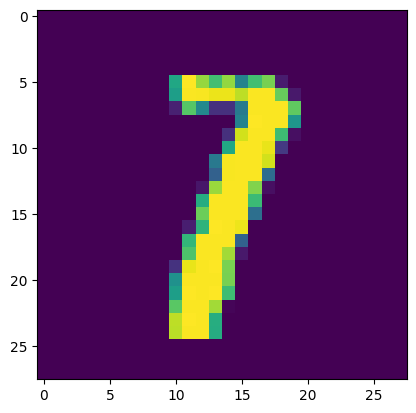

In [ ]:
plt.figure()
print('Image')
plt.imshow(mnist_example)
plt.show()

Similar


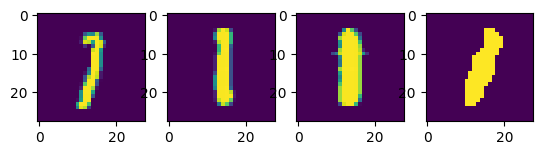

In [ ]:
fig = plt.figure()
print('Similar')
for index, image in enumerate(similar):
  fig.add_subplot(1, 4, index + 1)
  plt.imshow(image)
plt.show()

Different


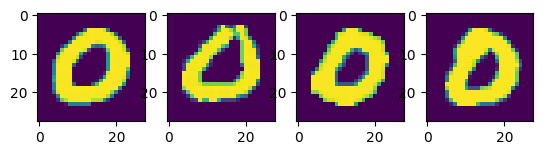

In [ ]:
fig = plt.figure()
print('Different')
for index, image in enumerate(different):
  fig.add_subplot(1, 4, index + 1)

  plt.imshow(image)
plt.show()